In [2]:
import pandas as pd
import numpy as np
import glob
from svv_read import Sub_SVV
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

/Users/sebastienvillard/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
sns.set_style("whitegrid")
sns.set(font="monospace", font_scale=1.5)
plt.rcParams['figure.figsize'] = 10,10
# pd.options.display.max_rows = 10

In [4]:
# create data frame for results3
df = pd.DataFrame()

readfolder = '../DATA/EXP2/'
list_subject = glob.glob(readfolder+'/S*')
# list_subject

## check following outliers

 - check S50: -20º values (bucket moved during test)
 - check S45: very high angle and very short RT
 - check S46: similar S45
 - check S47: low angles

In [5]:
for sub in list_subject:
    SUB = Sub_SVV(sub)
    df = df.append(SUB.create_table(), ignore_index=True)


In [6]:
# snb.stripplot(x='freq', y='SVV', data = df)
# snb.stripplot(x='freq', y='SVV', data = df[(df['stim']=='SH') & (df['SVV']>2.5)])

## check for Subjective Visual Vesrtical over 2.5º in control condition


In [7]:
outliers = [(np.abs(df.loc[i,'SVV'])>2.5) and (df.loc[i,'stim']=='CTRL') for i in df.index]
bad_id = df[outliers].id.unique()
df.insert(len(df.columns), 'Outliers', df['id'].isin(bad_id))

## graphical representation of SVV data with outliers in red

In [8]:
df.query('stim != "MX"').head()

,id,trial,stim,freq,rep,Angle_init,SVV,Reaction_time,Outliers
0,S67,T01,MF,120,T1,-21.060645,-0.527312,5030.0,False
1,S67,T18,AC,60,T0,-20.586103,-0.519436,3316.0,False
2,S67,T12,DC,0,T1,-24.734157,-2.567490,4143.0,False
3,S67,T09,AC,160,T1,-21.389072,-0.389072,4357.0,False
4,S67,T20,MF,20,T1,-22.588575,-1.121908,6114.0,False


In [9]:
df.stim.unique()

array(['MF', 'AC', 'DC', 'MX', 'CTRL'], dtype=object)

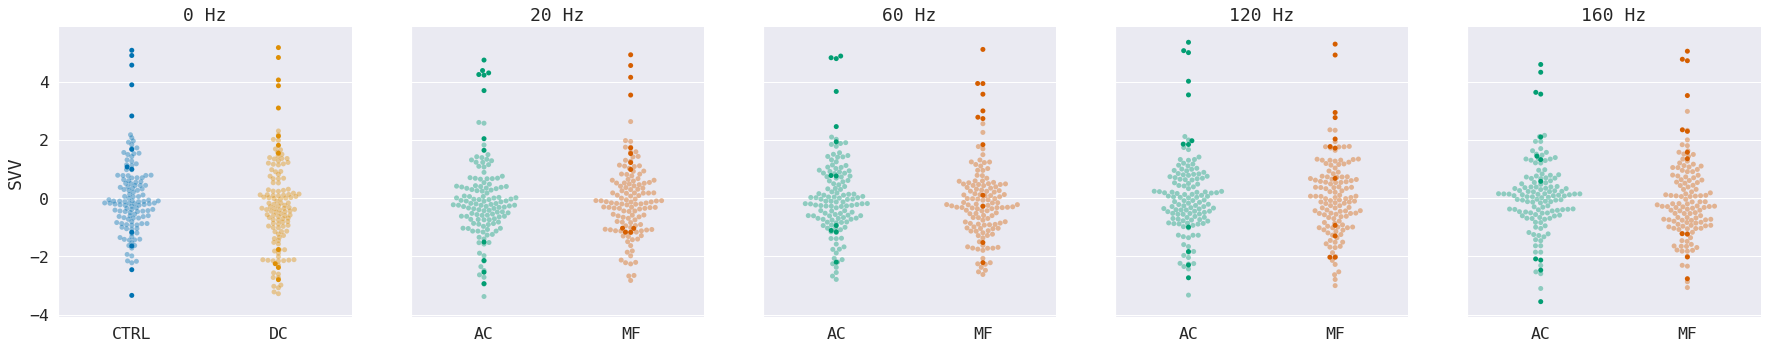

In [10]:
bool_good_id = ~df['id'].isin(bad_id)
bool_SHDC = df['freq'] == 0  # select CTRL and DC stimulation


if True:
    gdata = df.query('stim != "MX"')
    order = ['CTRL', 'DC', 'AC', 'MF']
    
    colorblind = sns.palettes.color_palette(palette='colorblind', n_colors=4)
    pal = dict(
        CTRL=colorblind[0], 
        DC=colorblind[1], 
        AC=colorblind[2],
        MF=colorblind[3]
    )
    
    g = sns.FacetGrid(gdata, 
                      col='freq', 
                      hue='Outliers',
                      hue_kws=dict(alpha=[0.4,1]),
                      sharex=False,
#                       aspect=0.8,
                      height=5
                     )  # check sns.catplot
                      
#     g.map(sns.swarmplot, 'stim', 'SVV', palette=pal, order=order, size=5, linewidth=1)
    
    for (i,j,k), data in g.facet_data():
        sorted_data = data.sort_values(by='stim')
        ax = g.facet_axis(i,j)
        s_pal = dict((k, v) for k, v in pal.items() if k in sorted_data.stim.unique())
        
        sns.swarmplot(data=sorted_data,
                     x='stim',
                     y='SVV',
                     hue='stim',
                     palette=s_pal,
                     alpha=g.hue_kws['alpha'][k]
                     )
        
        if j!=0:
            ax.set_ylabel('')
        
        ax.legend_.remove()
    
    g.set_titles("{col_name} Hz")
    g.set_xlabels('')
    

# Analysis over "good participants"

In [34]:
ndf = df[bool_good_id]  # remove subject with outliers SHAM data
ndf.insert(len(ndf.columns),'RT_deg',ndf['Reaction_time']/ndf['Angle_init'])  # create Time/deg column
ndf = ndf.drop(columns=['Angle_init','Reaction_time','Outliers'])
# ndf = ndf.groupby(['id','stim','freq']).mean()
ndf = ndf.groupby(['id','stim','freq']).agg(['mean', 'std'])

ref_svv = ndf.query('stim == "CTRL"')
ref_svv

SVV                RT_deg            
                   mean       std        mean         std
id  stim freq                                            
S40 CTRL 0    -0.133333  0.679324 -208.146214   41.908875
S41 CTRL 0     0.154135  0.243257 -234.387189   46.238781
S42 CTRL 0    -0.352208  0.578948 -342.433534  111.376731
S43 CTRL 0    -0.125796  0.677252 -246.017915   40.776383
S44 CTRL 0    -0.527896  1.049951 -207.852142   40.488410
S48 CTRL 0    -0.022167  0.578688 -181.923408   21.042953
S49 CTRL 0    -1.798269  0.382961 -247.766362   12.663750
S50 CTRL 0     0.253642  0.217998 -350.256220   71.848736
S51 CTRL 0    -0.555378  0.414193 -363.153273  145.748362
S52 CTRL 0     0.382002  1.490426 -230.482569   42.850183
S53 CTRL 0    -1.681689  0.439831 -587.224938   94.983089
S54 CTRL 0     1.268620  0.924760 -163.784373   33.168919
S55 CTRL 0    -0.294813  0.297003 -278.388746   55.814552
S56 CTRL 0     0.763077  0.984810 -441.505602   95.571349
S57 CTRL 0     0.225377  0.592006 -233.209494    6.519071
S58 CTRL 0     0.865960  1.288389 -241.813293   64.222366
S59 CTRL 0     0.429083  0.753770 -224.196330   60.405259
S60 CTRL 0     1.470021  0.659475 -357.031135   79.627859
S61 CTRL 0     1.138504  0.417715 -466.415470  148.686021
S62 CTRL 0    -0.003627  0.460234 -469.974310  210.316668
S63 CTRL 0    -0.440768  0.316877 -290.282924   93.070902
S64 CTRL 0     0.052419  0.493794 -258.519636   25.880480
S65 CTRL 0     1.028438  0.259659 -232.481115   64.644125
S66 CTRL 0    -0.618303  0.727939 -212.193287   55.925746
S67 CTRL 0    -0.560398  0.131709 -181.506866   33.078917
S68 CTRL 0    -0.663784  0.143318 -167.427528   28.593085
S69 CTRL 0    -1.179175  0.511735 -533.652934  148.772795
S70 CTRL 0    -0.779787  0.647332 -236.294071   58.901893
S71 CTRL 0    -1.151723  0.814615 -287.419798   43.957547
S72 CTRL 0     0.250464  0.503204 -275.686642   54.300679

In [31]:
ndf.head()

,id,trial,stim,freq,rep,SVV,RT_deg
0,S67,T01,MF,120,T1,-0.527312,-238.834089
1,S67,T18,AC,60,T0,-0.519436,-161.079540
2,S67,T12,DC,0,T1,-2.567490,-167.501161
3,S67,T09,AC,160,T1,-0.389072,-203.702155
4,S67,T20,MF,20,T1,-1.121908,-270.667808


## create new table with delta-SVV as difference SVVcond - SVVctrl

In [35]:
to_subtract = ref_svv.reset_index(level=[1,2], drop=True)
to_subtract

SVV                RT_deg            
         mean       std        mean         std
id                                             
S40 -0.133333  0.679324 -208.146214   41.908875
S41  0.154135  0.243257 -234.387189   46.238781
S42 -0.352208  0.578948 -342.433534  111.376731
S43 -0.125796  0.677252 -246.017915   40.776383
S44 -0.527896  1.049951 -207.852142   40.488410
S48 -0.022167  0.578688 -181.923408   21.042953
S49 -1.798269  0.382961 -247.766362   12.663750
S50  0.253642  0.217998 -350.256220   71.848736
S51 -0.555378  0.414193 -363.153273  145.748362
S52  0.382002  1.490426 -230.482569   42.850183
S53 -1.681689  0.439831 -587.224938   94.983089
S54  1.268620  0.924760 -163.784373   33.168919
S55 -0.294813  0.297003 -278.388746   55.814552
S56  0.763077  0.984810 -441.505602   95.571349
S57  0.225377  0.592006 -233.209494    6.519071
S58  0.865960  1.288389 -241.813293   64.222366
S59  0.429083  0.753770 -224.196330   60.405259
S60  1.470021  0.659475 -357.031135   79.627859
S61  1.138504  0.417715 -466.415470  148.686021
S62 -0.003627  0.460234 -469.974310  210.316668
S63 -0.440768  0.316877 -290.282924   93.070902
S64  0.052419  0.493794 -258.519636   25.880480
S65  1.028438  0.259659 -232.481115   64.644125
S66 -0.618303  0.727939 -212.193287   55.925746
S67 -0.560398  0.131709 -181.506866   33.078917
S68 -0.663784  0.143318 -167.427528   28.593085
S69 -1.179175  0.511735 -533.652934  148.772795
S70 -0.779787  0.647332 -236.294071   58.901893
S71 -1.151723  0.814615 -287.419798   43.957547
S72  0.250464  0.503204 -275.686642   54.300679

In [66]:
delta_svv = ndf.sub(to_subtract,axis=0, level=0)
delta_svv = delta_svv.rename(columns = {'SVV':'dSVV'})
delta_svv.columns = ['_'.join(col) for col in delta_svv.columns]
delta_svv.reset_index(level=['stim', 'freq'], inplace=True)
delta_svv.head()

,stim,freq,dSVV_mean,dSVV_std,RT_deg_mean,RT_deg_std
id,,,,,,
S40,AC,20,-0.675000,-0.228502,-14.781405,-20.603946
S40,AC,60,-0.033333,-0.459897,26.559257,-18.272001
S40,AC,120,-0.050000,-0.094010,1.334726,-6.308174
S40,AC,160,-0.108333,-0.059064,-6.586047,-19.713275
S40,CTRL,0,0.000000,0.000000,0.000000,0.000000


In [81]:
# %matplotlib auto
data = delta_svv.query('freq != 0 & stim != "MX"')
data.freq.astype(int)

var = 'dSVV_std'

g = sns.FacetGrid(data, col='stim')  # check sns.catplot
g.map(sns.boxplot, 'freq', var, palette='colorblind', order=[20, 60, 120, 160])
g.map(sns.swarmplot, 'freq', var, color='black', order=[20, 60, 120, 160])
g.set_xlabels('Frequency (Hz)')
g.set_ylabels(r'$\delta SVV$ (deg)')

# sns.despine(offset=10, trim=True);a

if False:
    h = sns.FacetGrid(data, col='stim')
    h.map(sns.boxplot, 'freq', 'RT_deg_mean', palette='colorblind')
    h.map(sns.swarmplot, 'freq', 'RT_deg_mean', color='black')

# sns.boxplot(x='freq', y='SVV', data=data, hue='stim', palette='colorblind')
# sns.swarmplot(x='freq', y='SVV', data=data, hue='stim')


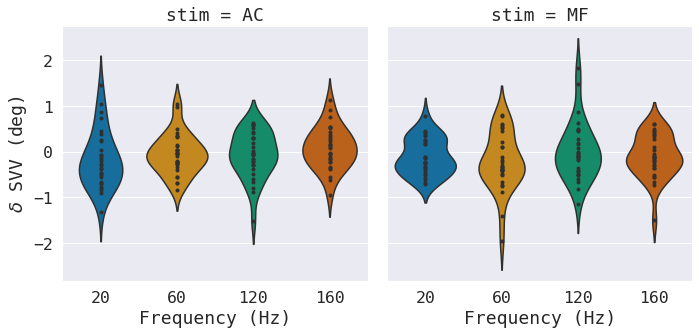

In [41]:
k = sns.catplot(data=data,
           kind='violin',
           x='freq',
           y='dSVV',
           col='stim',
           palette='colorblind',
           inner='points')

k.set_xlabels('Frequency (Hz)')
k.set_ylabels(r'$\delta$ SVV (deg)')

# Explore SVV variability:
In order to discuss potential effect of frequency of an alternating stimulation on SVV we decided to explore what could be the effect on the stability of the SVV adjustement over different exposure.

In [22]:
std_df = df[bool_good_id]
std_df.head()

,id,trial,stim,freq,rep,Angle_init,SVV,Reaction_time,Outliers
0,S67,T01,MF,120,T1,-21.060645,-0.527312,5030.0,False
1,S67,T18,AC,60,T0,-20.586103,-0.519436,3316.0,False
2,S67,T12,DC,0,T1,-24.734157,-2.567490,4143.0,False
3,S67,T09,AC,160,T1,-21.389072,-0.389072,4357.0,False
4,S67,T20,MF,20,T1,-22.588575,-1.121908,6114.0,False


In [28]:
std_df = std_df.drop(columns=['trial', 'rep', 'Angle_init', 'Reaction_time', 'Outliers'])
std_df.groupby(['id', 'stim', 'freq']).std()

SVV
id  stim freq          
S40 AC   20    0.450822
         60    0.219427
         120   0.585314
         160   0.620260
    CTRL 0     0.679324
...                 ...
S72 MF   20    0.080762
         60    0.373004
         120   0.152760
         160   0.481843
    MX   60    0.487583

[330 rows x 1 columns]

In [29]:
ndf.head()

,id,trial,stim,freq,rep,Angle_init,SVV,Reaction_time,Outliers
0,S67,T01,MF,120,T1,-21.060645,-0.527312,5030.0,False
1,S67,T18,AC,60,T0,-20.586103,-0.519436,3316.0,False
2,S67,T12,DC,0,T1,-24.734157,-2.567490,4143.0,False
3,S67,T09,AC,160,T1,-21.389072,-0.389072,4357.0,False
4,S67,T20,MF,20,T1,-22.588575,-1.121908,6114.0,False


## Export data for Analysis

In [17]:
# data.to_csv('TableRes_delta.csv')

In [18]:
fig = plt.gcf()

<Figure size 432x288 with 0 Axes>

In [19]:
fig.savefig('deltaSVV.png', dpi=300)